# Распознавание текста писателей

In [ ]:
import keras
print(keras.__version__)

3.4.1


## Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip

--2024-08-08 09:35:32--  https://storage.yandexcloud.net/academy.ai/russian_literature.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21547079 (21M) [application/x-zip-compressed]
Saving to: ‘russian_literature.zip’

russian_literature. 100%[===================>]  20.55M  4.91MB/s    in 9.8s    

2024-08-08 09:35:43 (2.09 MB/s) - ‘russian_literature.zip’ saved [21547079/21547079]



In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -O utf8 -qo "russian_literature" -d ./dataset

In [ ]:
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Bryusov"]

In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой


all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

## Токенизация. ТОКЕНАЙЗЕР ИЗ KERAS

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [ ]:
ind = min(len(seq_train[cls]) for cls in range(len(CLASS_LIST)))
seq_train_balance = [seq_train[cls][:ind] for cls in range(len(CLASS_LIST))]

In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 1150000 слов


### Балансировка датасета

In [ ]:
import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 230000 слов, доля в общей базе: 20.00%
Tolstoy - 230000 слов, доля в общей базе: 20.00%
Turgenev - 230000 слов, доля в общей базе: 20.00%
Chekhov - 230000 слов, доля в общей базе: 20.00%
Bryusov - 230000 слов, доля в общей базе: 20.00%
Среднее значение слов:  230000.0
Медианное значение слов:  230000.0


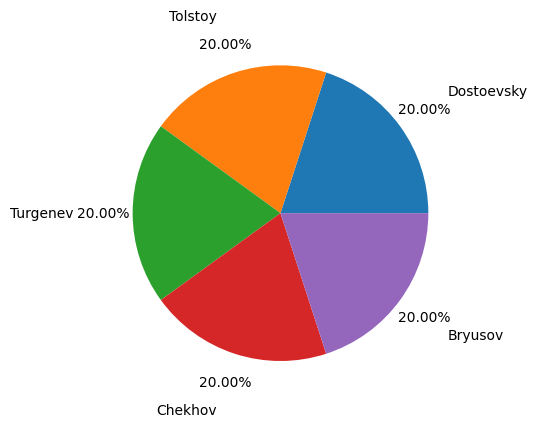

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

### Создание обучающей и проверочной выборок методом скользящего окна

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (10305, 1000)
Форма выходных данных (меток) для обучающей выборки: (10305, 5)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1105, 1000)
Форма выходных данных (меток) для тестовой выборки: (1105, 5)


### Вспомогательные функции

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


### Загрузка предобученных Embedding

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-08-08 09:38:02--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 3.5s    

2024-08-08 09:38:07 (14.4 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
!pip install navec

In [ ]:
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

### Загрузка весов

In [ ]:
import numpy as np

word_index = tokenizer.word_index
embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Архитектура сети

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout

embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000      # Количество слов, рассматриваемых как признаки

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=embedding_matrix))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Замораживаем слой Embedding
model.layers[0].trainable = False

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath = 'best_model_pretrain.keras',
                monitor = 'val_accuracy',
                save_best_only = True,
                mode = 'max',
                verbose = 0
                )
]

### Обучение модели

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=callbacks)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4743 - loss: 1.6348 - val_accuracy: 0.0000e+00 - val_loss: 26.4009
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9888 - loss: 0.0348 - val_accuracy: 0.0000e+00 - val_loss: 16.0014
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9969 - loss: 0.0112 - val_accuracy: 0.4908 - val_loss: 1.7705
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.8778 - val_loss: 0.3665
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9988 - loss: 0.0059 - val_accuracy: 0.9059 - val_loss: 0.2745
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9108 - val_loss: 0.2504
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.9321 - val_loss: 0.2020
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9993 - loss: 0.0023 - val_a

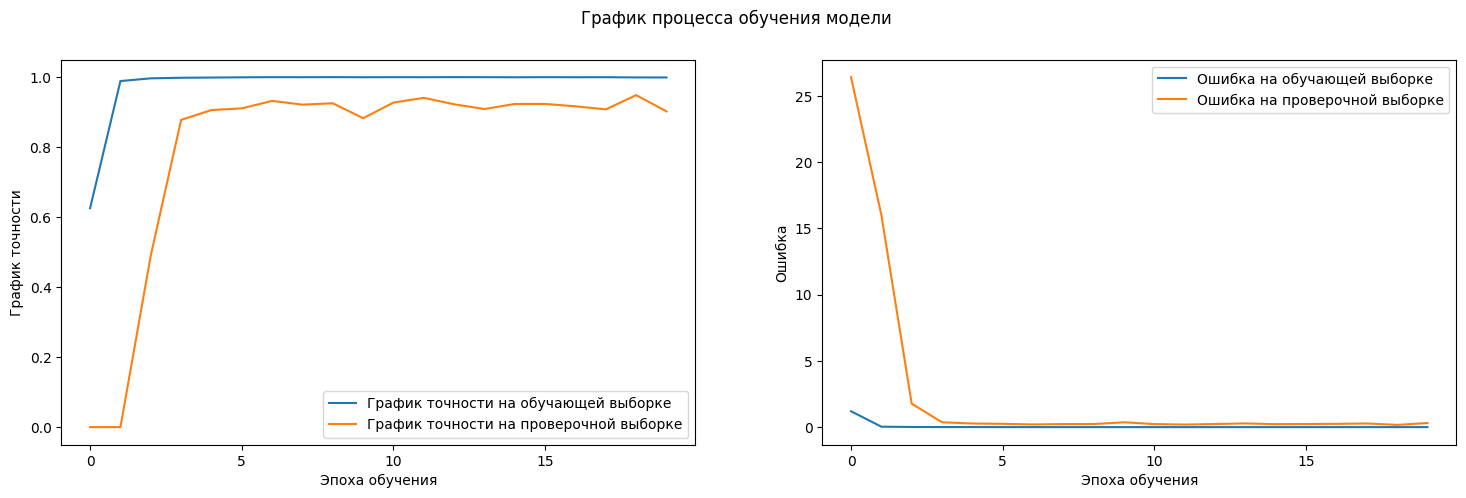

In [ ]:
show_plot(history)

In [ ]:
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = keras.models.load_model('best_model_pretrain.keras')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


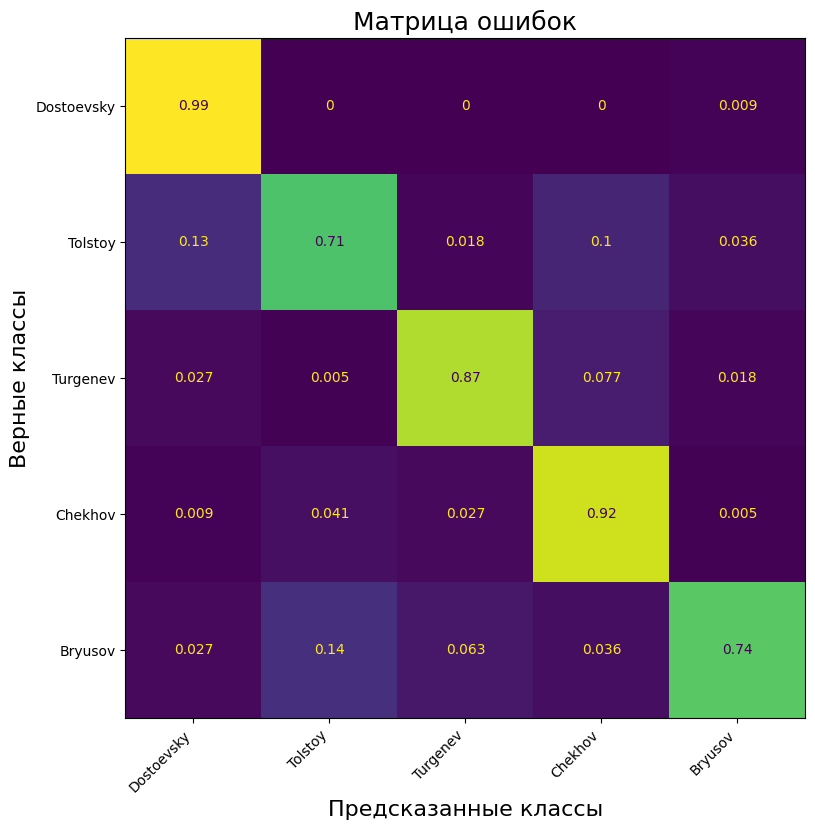


Средняя точность распознавания:  85%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

## Токенизация. ТОКЕНАЙЗЕР RAZDEL

In [ ]:
!pip install razdel

In [ ]:
def filter_text(text):
    filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff'
    text = ''.join(filter(lambda x: x not in filters, text))
    text = ' '.join(map(lambda x: x.lower(), text.split()))
    return text

filter_text(all_texts['Dostoevsky'][:100])

'слабое сердце повесть под одной кровлей в одной квартире в одном четвертом этаже жили два'

### Создание обучающей и проверочной выборок методом скользящего окна

In [ ]:
from razdel import tokenize
from collections import Counter

NUM_WORDS = 10000
# Пример текста

# Токенизация текста и построение словаря частотности
tokenized_texts = [list(tokenize(filter_text(text))) for text in all_texts.values()]
#print(tokenized_texts)
all_tokens = [token.text for sublist in tokenized_texts for token in sublist]
all_tokens_right = list(set(all_tokens))

#print(all_tokens)
token_counter = Counter(all_tokens)

# Сортировка токенов по частотности и создание индекса
sorted_tokens = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)
sorted_tokens_right = sorted_tokens[:NUM_WORDS]
sorted_tokens_right.insert(0,('неизвестное_слово', len(sorted_tokens[NUM_WORDS:])))
word_index = {token[0]: idx + 1 for idx, token in enumerate(sorted_tokens_right)}
#print(sorted_tokens)

# Добавление токена для неизвестных слов
#word_index['неизвестное_слово'] = len(word_index) + 1
#print(word_index)
# Преобразование текстов в последовательности индексов
seq_train = [[word_index.get(token.text, word_index['неизвестное_слово']) for token in text] for text in tokenized_texts]

In [ ]:
ind = min(len(seq_train[cls]) for cls in range(len(CLASS_LIST)))
seq_train_balance = [seq_train[cls][:ind] for cls in range(len(CLASS_LIST))]

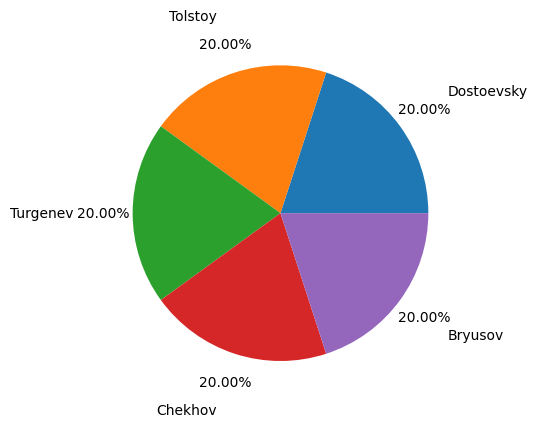

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (12920, 1000)
Форма выходных данных (меток) для обучающей выборки: (12920, 5)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1395, 1000)
Форма выходных данных (меток) для тестовой выборки: (1395, 5)


### Загрузка весов

In [ ]:
embeddings_index = navec
embedding_matrix = np.zeros((NUM_WORDS, 300))
for word, i in word_index.items():
    if i < NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Архитектура сети

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=embedding_matrix))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Замораживаем слой Embedding
model.layers[0].trainable = False

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0),
    keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    mode='max',
                    min_delta=0.001,
                    patience = 4),
]

### Обучение модели

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=callbacks)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4914 - loss: 1.5619 - val_accuracy: 0.0000e+00 - val_loss: 7.1548
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9792 - loss: 0.0579 - val_accuracy: 0.7655 - val_loss: 0.6831
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9950 - loss: 0.0172 - val_accuracy: 0.9412 - val_loss: 0.2126
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9968 - loss: 0.0095 - val_accuracy: 0.8986 - val_loss: 0.3752
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9350 - val_loss: 0.2148
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9443 - val_loss: 0.2017
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9365 - val_loss: 0.2272
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accura

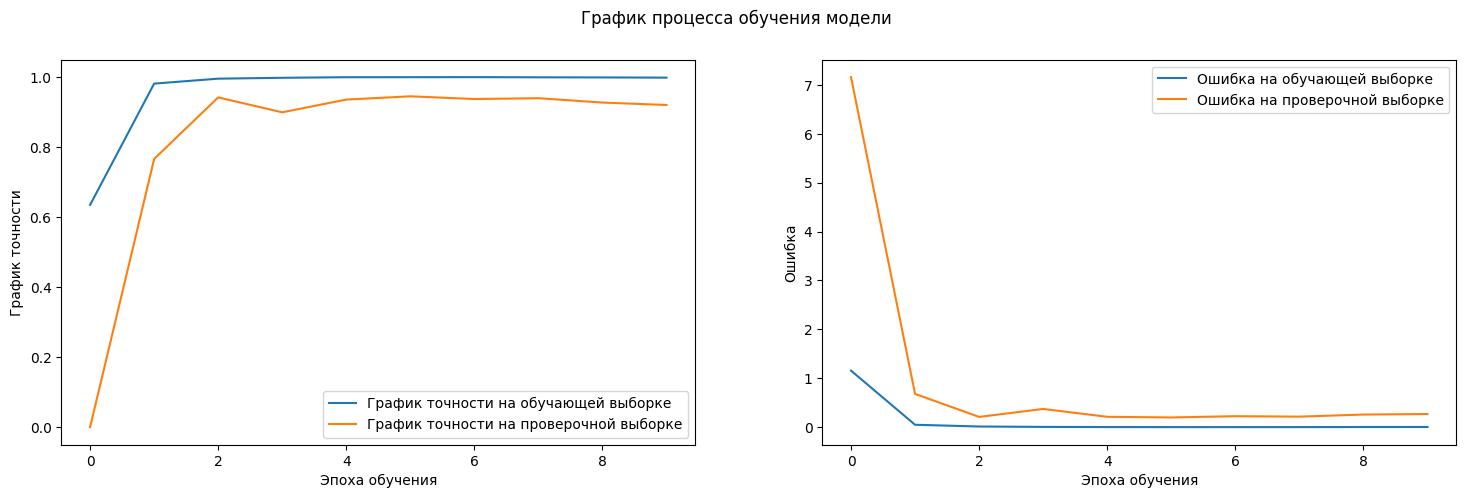

In [ ]:
show_plot(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


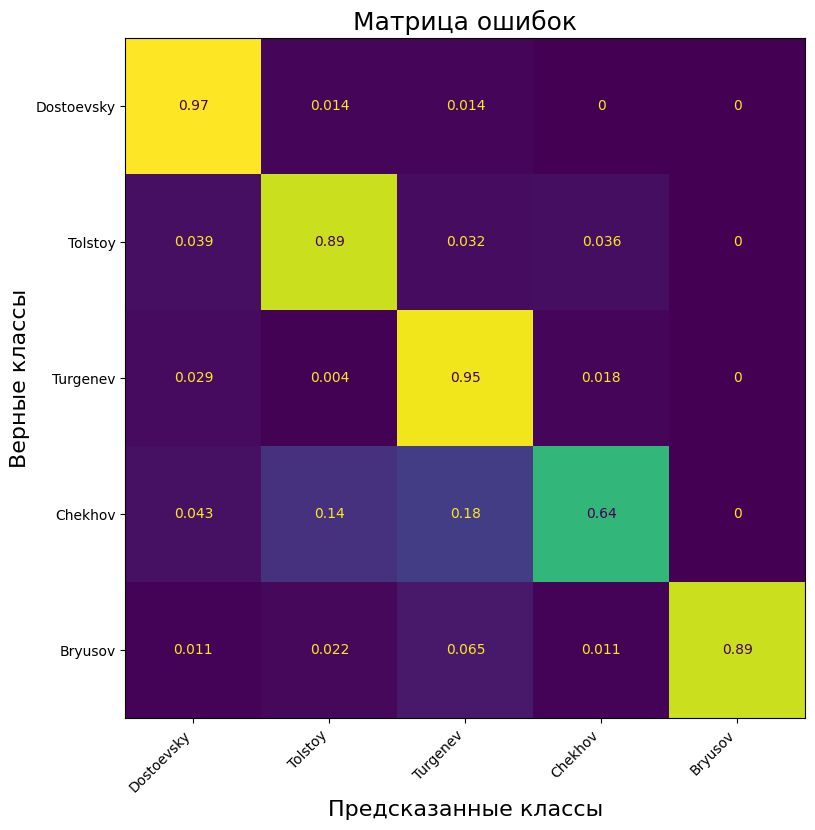


Средняя точность распознавания:  87%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)